# **05_PredictingAsthma**

## Objectives

* Fit and evaluate a classification model to predict whether a patient will have asthma, or not.

## Inputs

* Raw data generated from "01_DataCollection". Saved as: inputs\datasets\raw\asthma_disease_data.csv
* Confirmation of transformations and required scaling for continuous / numerical features from 04_FeatureEngineering; no additional data cleaning was required as no missing data.

## Outputs

* Data cleaning and Feature Engineering pipeline
* Modeling pipeline

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/AsthmaBurden/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/AsthmaBurden'

---

In [4]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    StratifiedKFold
)
from sklearn.metrics import (
    make_scorer,
    recall_score,
    confusion_matrix,
    classification_report
)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier
)

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

from feature_engine.wrappers import SklearnTransformerWrapper

from xgboost import XGBClassifier


# Pipeline with all features 

Load data - Collection dataset was loaded and the target feature (Diagnosis) was assigned 

In [5]:
df = (pd.read_csv("outputs/datasets/collection/asthma_disease_data.csv").drop(['DoctorInCharge', 'PatientID'], axis=1))
target_var = "Diagnosis"
df.head(5)

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,...,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,...,0,3.470589,3.067944,1,1,1,0,0,1,0


## Pipeline for data cleaning and feature engineering
---

1) Apply relevant learnings from 03_FeatureEngineering with regards to continuous features; reminder that no features were highly correlated (SmartCorrelatedSelection) and categorical features were already binary:

In [6]:
# Feature Engineering
def PipelineDataCleaningAndFeatureEngineering():
    """
    Custom function to apply transformations required.
    Yeo-Johnson transformation selected as the best option in feature engineering"""
    pipeline_base = Pipeline([
        ('yeojohnson_transform', SklearnTransformerWrapper(
        transformer=PowerTransformer(method='yeo-johnson'),
        variables=['BMI',
            'LungFunctionFEV1', 'LungFunctionFVC',
            'SleepQuality'])
        )
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('yeojohnson_transform', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,transformer,PowerTransformer()
,variables,"['BMI', 'LungFunctionFEV1', ...]"
,"method method: {'yeo-johnson', 'box-cox'}, default='yeo-johnson'The power transform method. Available methods are:- 'yeo-johnson' [1]_, works with positive and negative values- 'box-cox' [2]_, only works with strictly positive values",'yeo-johnson'
,"standardize standardize: bool, default=TrueSet to True to apply zero-mean, unit-variance normalization to thetransformed output.",True
,"copy copy: bool, default=TrueSet to False to perform inplace computation during transformation.",True


2. Due to the imbalanced nature of the dataset, little to no features were deemed to have a significant association with asthma diagnosis (minority sample). This was investigated further to understand overarching correlation with the target feature

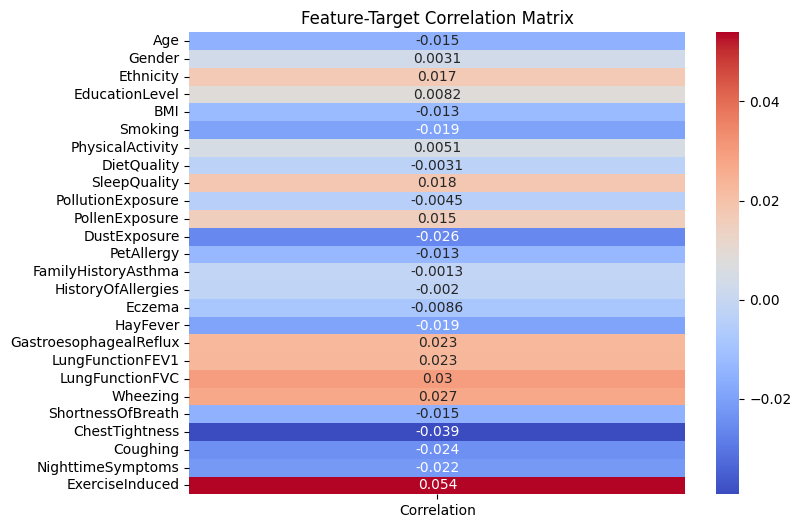

Index(['DustExposure', 'LungFunctionFVC', 'Wheezing', 'ChestTightness',
       'ExerciseInduced'],
      dtype='str')

In [7]:
features = df.drop(['Diagnosis'], axis=1)
target = df['Diagnosis']

correlation_matrix = features.corrwith(target)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(correlation_matrix, columns=['Correlation']), annot=True, cmap='coolwarm', cbar=True)
plt.title('Feature-Target Correlation Matrix')
plt.show()

threshold = 0.025
columns_to_drop = correlation_matrix[abs(correlation_matrix) < threshold].index
features = features.drop(columns_to_drop, axis=1)
features.columns

4. Define the classifier pipeline, apply feature scaling for continuous features and run pipeline for hyperparameter optimisation (taken from the Code Institutes "Churnometer" walkthrough project):

In [8]:
class SafeSelectFromModel(BaseEstimator, TransformerMixin):
    """
    A safe wrapper around SelectFromModel to ensure at least min_features are kept.
    """
    def __init__(self, selector, min_features=1):
        self.selector = selector
        self.min_features = min_features

    def fit(self, X, y=None):
        self.selector.fit(X, y)
        mask = self.selector.get_support()
        
        # Ensure at least min_features are kept
        if mask.sum() < self.min_features:
            mask[:self.min_features] = True
        self.mask_ = mask
        return self

    def transform(self, X):
        return X[:, self.mask_]

def PipelineClf(model, use_feature_selection=True, use_smote=True,
                smote_ratio=1.0, k_neighbors=75,
                feature_selection_threshold='median', min_features=1,
                smote_kind='borderline-2', use_scaling=True, class_weight='balanced', 
                feature_selection_method="select_from_model"):
    """
    Classification pipeline with feature scaling, optional feature selection,
    and Borderline-SMOTE oversampling.
    """
    # Clone the model to avoid modifying the original model
    model_copy = clone(model)

    # Apply class_weight if supported by the model
    if 'class_weight' in model_copy.get_params():
        model_copy.set_params(class_weight=class_weight)

    # Initialize the list of steps for the pipeline
    steps = []

    # Apply scaling if requested
    if use_scaling:
        steps.append(('scaler', StandardScaler()))

    # Apply Borderline-SMOTE if requested
    if use_smote:
        steps.append(('smote', BorderlineSMOTE(
            kind=smote_kind,  # Type of Borderline-SMOTE to use
            sampling_strategy=smote_ratio,  # Ratio of oversampling
            k_neighbors=k_neighbors,  # Number of neighbors to use
            random_state=42
        )))

    # Apply feature selection if requested
    if use_feature_selection:
        # Select feature selection method
        if feature_selection_method == "select_from_model":
            selector = SelectFromModel(model_copy, threshold=feature_selection_threshold)
        elif feature_selection_method == "select_k_best":
            selector = SelectKBest(f_classif, k=min_features)
        elif feature_selection_method == "rfe":
            selector = RFE(model_copy, n_features_to_select=min_features)
        else:
            raise ValueError("Invalid feature selection method")

        # Add the feature selection step with SafeSelectFromModel
        steps.append(('feat_selection', SafeSelectFromModel(selector, min_features=min_features)))

    # Add the final model to the pipeline
    steps.append(('model', model_copy))

    # Create and return the imbalanced-learn pipeline
    pipeline_base = ImbPipeline(steps)
    return pipeline_base

5. Use a customised function for hyperparameter optimisation (adapted from The Code Institutes walkthough through project, "Churnometer")

In [9]:
class HyperparameterOptimizationSearch:
    """
    Custom class for hyperparameter optimization supporting both GridSearchCV and RandomizedSearchCV.
    """
    def __init__(self, models, params, search_type='grid', n_iter=10, random_state=None):
        self.models = models
        self.params = params
        self.keys = list(models.keys())  # Make sure this is a list, not a dict_keys object
        self.search_type = search_type.lower()
        self.n_iter = n_iter
        self.random_state = random_state
        self.searches = {}

    def fit(self, X, y, cv=5, n_jobs=-1, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            print(f"\nRunning {self.search_type.title()}SearchCV for {key} \n")

            model = PipelineClf(self.models[key])  # keep your custom pipeline wrapper

            if self.search_type == 'grid':
                search = GridSearchCV(model, self.params[key], cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=refit)
            elif self.search_type == 'random':
                search = RandomizedSearchCV(model, self.params[key], n_iter=self.n_iter,
                                            cv=cv, n_jobs=n_jobs, verbose=verbose,
                                            scoring=scoring, refit=refit,
                                            random_state=self.random_state)
            else:
                raise ValueError("search_type must be either 'grid' or 'random'.")

            search.fit(X, y)
            self.searches[key] = search

    def score_summary(self, sort_by='mean_score'):
        """
        Returns a summary dataframe of the search results.
        """
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': np.min(scores),
                'max_score': np.max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.searches:
            search = self.searches[k]
            params = search.cv_results_['params']
            all_scores = []

            # Iterate through the number of splits and handle cases where splits are missing
            for i in range(len(search.cv_results_['mean_test_score'])):
                score_key = 'split{}_test_score'.format(i)
                if score_key in search.cv_results_:
                    scores = search.cv_results_[score_key]  # Access the test scores for each split
                    all_scores.append(scores)
                else:
                    print(f"Warning: {score_key} not found in cv_results_")

            if all_scores:
                all_scores = np.array(all_scores).T  # Transpose to align with params
                for p, s in zip(params, all_scores):
                    rows.append(row(k, s, p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns += [c for c in df.columns if c not in columns]
        return df[columns], self.searches



## Preparing the data
---

1. Update Age, Ethnicity and Education to align with 03_DataExploration

In [10]:
df['Age'] = df['Age'].astype(float)

# Encode categories
df['Ethnicity'] = df['Ethnicity'].replace({0:0, 1:1, 2:1, 3:1})
df['EducationLevel'] = df['EducationLevel'].replace({1:1, 2:1, 3:0})

df.head(10)

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63.0,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26.0,1,1,1,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57.0,0,1,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40.0,1,1,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,...,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61.0,0,0,0,19.283802,0,4.604493,3.127048,9.625799,0.980875,...,0,3.470589,3.067944,1,1,1,0,0,1,0
5,21.0,0,1,0,21.812975,0,0.470044,1.759118,9.549262,1.711446,...,0,2.328191,5.898515,1,0,1,0,0,1,0
6,45.0,1,1,1,30.245954,1,9.371784,7.030507,5.746128,7.664306,...,0,2.995100,1.701512,1,1,1,0,0,0,0
7,26.0,0,0,1,26.048416,1,8.344096,1.626484,6.431179,6.939046,...,0,2.069343,4.012260,1,0,0,1,1,1,0
8,49.0,1,1,1,32.676204,0,2.690256,3.920034,5.843645,3.180421,...,1,1.761242,5.190931,1,1,1,1,0,0,0
9,45.0,1,1,1,29.910298,0,2.895720,2.607700,7.234908,1.711722,...,0,2.848420,5.771022,1,0,0,0,1,1,0


2. Split the train and test set with stratifications, due to the small base for analyses

In [11]:
# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    df.drop([target_var], axis=1), 
    df[target_var],
    test_size=0.25,
    random_state=0,
    stratify=df[target_var]
)

# Split X_temp into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.25,
    random_state=0,
    stratify=y_temp
)

# Check shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (1345, 26)
y_train: (1345,)
X_val: (449, 26)
y_val: (449,)
X_test: (598, 26)
y_test: (598,)


3. Check the split of the target variable across the train and test set

In [12]:
# Check counts
print("Asthma count in train:", y_train.value_counts())
print("Asthma count in validation:", y_val.value_counts())
print("Asthma count in test:", y_test.value_counts())

Asthma count in train: Diagnosis
0    1275
1      70
Name: count, dtype: int64
Asthma count in validation: Diagnosis
0    426
1     23
Name: count, dtype: int64
Asthma count in test: Diagnosis
0    567
1     31
Name: count, dtype: int64


4. Apply transformations to the train and test set

In [13]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_val = pipeline_data_cleaning_feat_eng.transform(X_val)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)

## Grid Search CV - Sklearn


---

Multiple machine learning models were evaluated to provide baseline performance and enable easy comparison:
* Linear models include logistic regression (predicts probability for binary outcomes using a logistic function) and ridge classifier.
* Tree-based models split the data based on feature thresholds to make predictions, and hangle non-linearities (decision tree, random forest)
* Boosting models look at each new model, and corrects errors of the previous one sequentially (XGBoost, CatBoost, AdaBoost, Gradient Boosting)

In [14]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0, class_weight='balanced'),
    "XGBClassifier": XGBClassifier(random_state=0, scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum()),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0, class_weight='balanced'),
    "RandomForestClassifier": RandomForestClassifier(random_state=0, class_weight='balanced'),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0), 
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0, class_weight='balanced'),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# Optional: keep empty hyperparameter grids for now
params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


Primary metrics for choosing the best model:
* Recall for asthma ≥ 0.80 – to minimize false negatives (diagnosed asthma cases predicted as non-asthma), ensuring sensitive detection of patients who actually have asthma.
* Precision for asthma ≥ 0.60 – to reduce false positives, avoiding over-identifying healthy patients as asthmatic.

GridSearchCV was run evaluate the model performance using the default hyperparameters; 5-fold cross-validation to obtain a robust estimate of model performance and reduce the impact of random variation in the training data.

In [15]:
# Define your StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up your search (assuming models_quick_search and params_quick_search are defined)
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fit the search with the StratifiedKFold CV and custom scoring (recall)
search.fit(X_train, y_train, scoring='recall', n_jobs=-1, cv=cv)  # Pass StratifiedKFold as the cv



Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Recall results:

In [16]:
search_summary, search_pipelines = search.score_summary(sort_by='mean_score')
search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.214286,0.214286,0.214286,0.0
6,AdaBoostClassifier,0.142857,0.142857,0.142857,0.0
1,XGBClassifier,0.071429,0.071429,0.071429,0.0
4,GradientBoostingClassifier,0.071429,0.071429,0.071429,0.0
2,DecisionTreeClassifier,0.0,0.0,0.0,0.0
3,RandomForestClassifier,0.0,0.0,0.0,0.0
5,ExtraTreesClassifier,0.0,0.0,0.0,0.0


Among the tested algorithms, the best-performing model was the XXXXX. However, this is significnatly below the requirements for the business case, meaning hyperparamters will need to be optimised. To understand best ways for tuning Hyperparameters, online sources, such as geeksforfeeks and towardsdatascience were utilised.

In [17]:
# Define the AdaBoostClassifier model
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(
        random_state=42
    )
}

# Define the hyperparameters for AdaBoost
adaboost_params = {
    'model__n_estimators': [100, 120, 150, 180],
    'model__learning_rate': [0.01, 0.05, 0.1],  # Lower learning rate
}

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = HyperparameterOptimizationSearch(
    models=models_search,
    params={"AdaBoostClassifier": adaboost_params},  # Corrected to AdaBoost params
    search_type='random',  # Randomized search
    n_iter=50,  # Number of iterations for random search
    random_state=42
)

search.fit(
    X_train,
    y_train,
    cv=cv,  # Use StratifiedKFold as cross-validation
    scoring='recall',  # Using recall as the scoring metric
    n_jobs=-1  # Use all processors for parallel computation
)


Running RandomSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Check results - Recall:

In [19]:
search_summary, search_pipelines = search.score_summary(sort_by='mean_score')
search_summary

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators,model__learning_rate
1,AdaBoostClassifier,0.357143,0.542857,0.785714,0.153862,120,0.01
2,AdaBoostClassifier,0.357143,0.542857,0.785714,0.153862,150,0.01
0,AdaBoostClassifier,0.357143,0.528571,0.785714,0.160357,100,0.01
3,AdaBoostClassifier,0.357143,0.5,0.642857,0.101015,180,0.01
4,AdaBoostClassifier,0.357143,0.457143,0.571429,0.072843,100,0.05
5,AdaBoostClassifier,0.285714,0.414286,0.571429,0.114286,120,0.05
6,AdaBoostClassifier,0.285714,0.414286,0.571429,0.114286,150,0.05
7,AdaBoostClassifier,0.285714,0.414286,0.571429,0.104978,180,0.05
8,AdaBoostClassifier,0.285714,0.414286,0.571429,0.094761,100,0.1
9,AdaBoostClassifier,0.285714,0.4,0.5,0.072843,120,0.1


In [20]:
y_pred = search_pipelines['AdaBoostClassifier'].best_estimator_.predict(X_train)

# Compute confusion matrix
train_confusion_matrix= confusion_matrix(y_train, y_pred)

print("Confusion Matrix:")
print(train_confusion_matrix)

Confusion Matrix:
[[667 608]
 [ 24  46]]


Define the best model and paramters for the best pipeline:

In [21]:
# State the best model 
best_model = search_summary.iloc[0, 0]

# Get best parameters and best estimator
best_parameters = search_pipelines[best_model].best_params_
pipeline_clf = search_pipelines[best_model].best_estimator_

best_parameters, pipeline_clf

({'model__n_estimators': 120, 'model__learning_rate': 0.01},
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('smote',
                  BorderlineSMOTE(k_neighbors=75, kind='borderline-2',
                                  random_state=42, sampling_strategy=1.0)),
                 ('feat_selection',
                  SafeSelectFromModel(selector=SelectFromModel(estimator=AdaBoostClassifier(random_state=42),
                                                               threshold='median'))),
                 ('model',
                  AdaBoostClassifier(learning_rate=0.01, n_estimators=120,
                                     random_state=42))]))

## Step seven: Assess Feature Importance
---

In [ ]:
X_train.head(3)

From our pipeline, we're able to identify which features were selected (used in the model) and which ones were deemed important. As this dataset included a small pool of asthma patients, there was a high risk of overfitting the model. For this reason, SelectFromModel was limited to include the most important features only. In the dataset,6 features were selected.

In [ ]:
# Create DataFrame of selected features and their importances
df_feature_importance = pd.DataFrame({
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Save feature order
best_features = df_feature_importance['Feature'].to_list()

# Define substantial features threshold
threshold = 0.5 # change
df_feature_importance['Substantial'] = df_feature_importance['Importance'] >= threshold

# Most important features statement and plot 
print( f"* These are the {len(best_features)} most important features in " f"descending order. The model was trained on them:\n" f"{df_feature_importance['Feature'].to_list()}" )

# Plot feature importances, coloring substantial features differently
colors = np.where(df_feature_importance['Substantial'], 'orange', 'lightblue')

ax = df_feature_importance.plot(kind='bar', x='Feature', y='Importance', color=colors, legend=False)
plt.title('Feature Importances (Substantial features in orange)')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Evaluate Pipeline on Train and Test sets
---

In [ ]:
# From Churnometer Walkthrough Project
def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=y, y_pred=prediction),columns=[["Prediction " + sub for sub in label_map]], index=[["Actual " + sub for sub in label_map]]))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_val, y_val, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Validation Set ####\n")
    confusion_matrix_and_report(X_val, y_val, pipeline, label_map)


In [ ]:
clf_performance(
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    pipeline=pipeline_clf,
    label_map=['No asthma', 'Asthma']
)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.